In [1]:
import os
import time
import glob
import pickle
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.special import expit
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from baseline import *

In [2]:
seed = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device=="cuda":
    torch.cuda.manual_seed(seed)

## Prepare Dataset

In [3]:
lp_train = pickle.load(open('data/cora/lp_train.pkl', 'rb'))
lp_test = pickle.load(open('data/cora/lp_test.pkl', 'rb'))

node_features = pickle.load(open('data/cora/node_features.pkl', 'rb'))
text_features = node_features.toarray()
nnodes = text_features.shape[0]

pca = PCA(n_components=100)
pca.fit(text_features)
emb_features = pca.transform(text_features)
emb_features = torch.from_numpy(emb_features).to(device).float()
    
adjs = defaultdict(set)
for node in list(lp_train.nodes()):
    adjs[node] = adjs[node].union(lp_train[node])
adjs = [np.sort(list(v)) for k,v in adjs.items()]

## Parameters

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

nlayer = 1
dims = [100]*(nlayer+1)
dropout = 0.4

lr = 0.005
weight_decay = 0.0005

patience = 50
nepoch = 10000

## Link Prediction Supervised Training

In [5]:
posi, nega = [], []
for node in range(nnodes):
    neighbors = list(lp_train[node])
    nega_neighbors = random.sample(list(set(range(nnodes)).difference(set(neighbors))), 5)
    nega.append(np.stack(([node]*len(nega_neighbors), nega_neighbors), axis=-1))
    posi.append(np.stack(([node]*len(neighbors), neighbors), axis=-1))
posi = np.concatenate(posi, axis=0)
nega = np.concatenate(nega, axis=0)

X_train = np.concatenate([posi,nega], axis=0)
y_train = torch.from_numpy(np.concatenate([[1]*len(posi), [0]*len(nega)])).float().to(device)
X_test = lp_test[:,:-1]
y_test = torch.from_numpy(lp_test[:,-1]).float().to(device)

## Train & Test

In [6]:
def evaluate(cos_sim, labels):
    pred = expit(cos_sim)>0.5
    f1, accuracy = f1_score(labels, pred), accuracy_score(labels, pred)
    return accuracy, f1

In [7]:
pdist = nn.PairwiseDistance()

def edge_diff(embeds):
    diff = pdist(embeds[posi[:,0]], embeds[posi[:,1]])
    return torch.mean(diff).cpu().item()

def embed_diff(embeds, prev_embeds):
    diff = pdist(embeds, prev_embeds)
    return torch.mean(diff).cpu().item()

In [8]:
cos = nn.CosineSimilarity()

def sup_train(model, optimizer, epoch, prev_embeds):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    
    real_adjs = []
    for node, neighbors in enumerate(adjs):
        real_neighbors = random.sample(neighbors.tolist(), 1)
        real_neighbors.append(node)
        real_adjs.append(real_neighbors)
    
    embeds = model(emb_features, real_adjs)
    lp_input = torch.stack([embeds[X_train[:,0]], embeds[X_train[:,1]]])
    similarity = cos(lp_input[0], lp_input[1])
    loss = F.binary_cross_entropy_with_logits(similarity, y_train)
    
    accuracy, f1 = evaluate(similarity.detach().cpu().numpy(), y_train.cpu().numpy())
    curr_edge_diff = edge_diff(embeds)
    curr_embed_diff = embed_diff(embeds, prev_embeds)
    curr_input_diff = embed_diff(embeds, emb_features)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1)%1==0:
        print('Epoch: {} || Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f} || Edge_diff: {:.4f}, Embed_diff: {:.4f}, Input_diff: {:.4f} || Time: {:.4f}s'
              .format(epoch, loss.item(), accuracy, f1, curr_edge_diff, curr_embed_diff, curr_input_diff, time.time()-t))
    
    return loss.item(), curr_edge_diff, curr_embed_diff, curr_input_diff, embeds

In [9]:
def sup_test(model):
    model.eval()
    
    real_adjs = []
    for node, neighbors in enumerate(adjs):
        real_neighbors = random.sample(neighbors.tolist(), 1)
        real_neighbors.append(node)
        real_adjs.append(real_neighbors)
    
    embeds = model(emb_features, real_adjs)
    lp_input = torch.stack([embeds[X_test[:,0]], embeds[X_test[:,1]]])
    similarity = cos(lp_input[0], lp_input[1])
    loss = F.binary_cross_entropy_with_logits(similarity, y_test)
    
    accuracy, f1 = evaluate(similarity.detach().cpu().numpy(), y_test.cpu().numpy())
    
    print('Loss: {:.4f}, Acc: {:.4f}, F1: {:.4f}'.format(loss.item(), accuracy, f1))

In [10]:
t_total = time.time()

model = GraphSAGEModel(dims=dims, dropout=dropout, nlayer=nlayer, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

prev_embeds = emb_features
loss_values, edge_diffs, embed_diffs, input_diffs = [], [], [], []
bad_counter, best, best_epoch = 0, nepoch+1, 0
for epoch in range(nepoch):
    loss_value, curr_edge_diff, curr_embed_diff, curr_input_diff, prev_embeds = sup_train(model, optimizer, epoch, prev_embeds)
    
    loss_values.append(loss_value)
    edge_diffs.append(curr_edge_diff)
    embed_diffs.append(curr_embed_diff)
    input_diffs.append(curr_input_diff)
    
    torch.save(model.state_dict(), 'model/Supervised/{}.pkl'.format(epoch))
    
    if loss_values[-1] < best:
        best, best_epoch, bad_counter = loss_values[-1], epoch, 0
    else:
        bad_counter += 1
                
    if bad_counter == patience:
        break
        
    files = glob.glob('model/Supervised/*.pkl')
    for file in files:
        epoch_nb = int(file.split('.')[0].split('/')[-1])
        if epoch_nb < best_epoch:
            os.remove(file) 
    
files = glob.glob('model/Supervised/*.pkl')
for file in files:
    epoch_nb = int(file.split('.')[0].split('/')[-1])
    if epoch_nb > best_epoch:
        os.remove(file) 
        
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

print('Loading {}th epoch'.format(best_epoch))
model.load_state_dict(torch.load('model/Supervised/{}.pkl'.format(best_epoch)))

sup_test(model)

Epoch: 0 || Loss: 0.7066, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.8370, Embed_diff: 1.0149, Input_diff: 1.0149 || Time: 0.4785s
Epoch: 1 || Loss: 0.7049, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.8335, Embed_diff: 0.8333, Input_diff: 1.0146 || Time: 0.3268s
Epoch: 2 || Loss: 0.7030, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.8273, Embed_diff: 0.8333, Input_diff: 1.0146 || Time: 0.3051s
Epoch: 3 || Loss: 0.7002, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.8290, Embed_diff: 0.8174, Input_diff: 1.0145 || Time: 0.3469s
Epoch: 4 || Loss: 0.6990, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.8267, Embed_diff: 0.8096, Input_diff: 1.0144 || Time: 0.3007s
Epoch: 5 || Loss: 0.6943, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.8042, Embed_diff: 0.8116, Input_diff: 1.0144 || Time: 0.3494s
Epoch: 6 || Loss: 0.6925, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.8003, Embed_diff: 0.7974, Input_diff: 1.0142 || Time: 0.3205s
Epoch: 7 || Loss: 0.6903, Acc: 0.3871, F1: 0.5582 || Edge_diff: 0.8000, Embed_diff: 0.7959, Input_diff: 

Epoch: 64 || Loss: 0.6483, Acc: 0.3996, F1: 0.5631 || Edge_diff: 0.6662, Embed_diff: 0.6460, Input_diff: 1.0140 || Time: 0.3194s
Epoch: 65 || Loss: 0.6492, Acc: 0.3969, F1: 0.5619 || Edge_diff: 0.6717, Embed_diff: 0.6438, Input_diff: 1.0144 || Time: 0.3209s
Epoch: 66 || Loss: 0.6474, Acc: 0.4014, F1: 0.5637 || Edge_diff: 0.6708, Embed_diff: 0.6518, Input_diff: 1.0144 || Time: 0.3046s
Epoch: 67 || Loss: 0.6497, Acc: 0.4004, F1: 0.5634 || Edge_diff: 0.6728, Embed_diff: 0.6438, Input_diff: 1.0141 || Time: 0.3241s
Epoch: 68 || Loss: 0.6486, Acc: 0.3990, F1: 0.5624 || Edge_diff: 0.6690, Embed_diff: 0.6439, Input_diff: 1.0141 || Time: 0.3201s
Epoch: 69 || Loss: 0.6456, Acc: 0.3999, F1: 0.5632 || Edge_diff: 0.6537, Embed_diff: 0.6453, Input_diff: 1.0142 || Time: 0.3183s
Epoch: 70 || Loss: 0.6464, Acc: 0.4020, F1: 0.5640 || Edge_diff: 0.6676, Embed_diff: 0.6474, Input_diff: 1.0144 || Time: 0.3194s
Epoch: 71 || Loss: 0.6496, Acc: 0.4010, F1: 0.5636 || Edge_diff: 0.6736, Embed_diff: 0.6565, Inpu

Text(0.5, 1.0, 'Training Loss Curve')

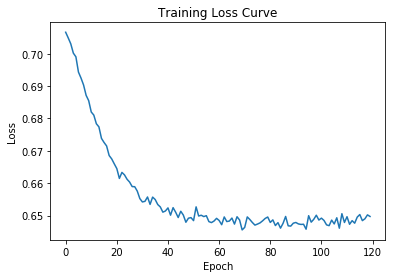

In [11]:
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')

Text(0.5, 1.0, 'Training Edge-wise Distance Curve')

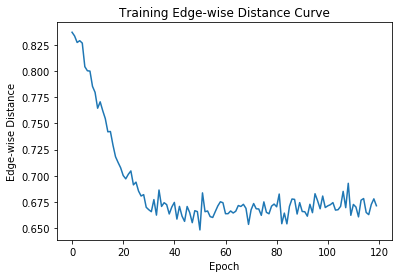

In [12]:
plt.plot(edge_diffs)
plt.xlabel('Epoch')
plt.ylabel('Edge-wise Distance')
plt.title('Training Edge-wise Distance Curve')

Text(0.5, 1.0, 'Change in Embedding Curve')

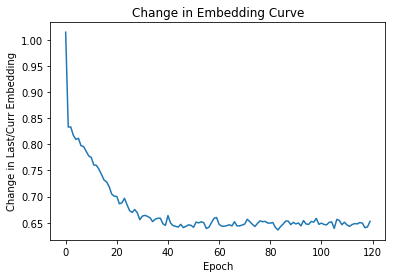

In [13]:
plt.plot(embed_diffs)
plt.xlabel('Epoch')
plt.ylabel('Change in Last/Curr Embedding')
plt.title('Change in Embedding Curve')

Text(0.5, 1.0, 'Change in Input/Output Curve')

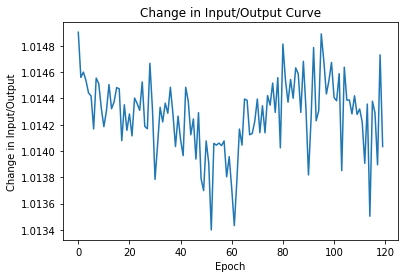

In [14]:
plt.plot(input_diffs)
plt.xlabel('Epoch')
plt.ylabel('Change in Input/Output')
plt.title('Change in Input/Output Curve')